# Convolutional Neural Network

In [ ]:
import pandas as pd
import numpy as np
import re
import fasttext
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/kaggle/input/sentimentdatav4/SentimentDataV4.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [3]:
texts = df['texts'].astype(str).tolist()
labels = df['label'].values

In [4]:
khmer_model = fasttext.load_model("/kaggle/input/embedding/cc.km.300.bin")
english_model = fasttext.load_model("/kaggle/input/embedding/cc.en.300.bin")


In [6]:
def is_khmer(word):
    return bool(re.search(r'[\u1780-\u17FF]', word))

In [7]:
# Manual transliteration dictionary
transliteration_dict = {
    "trov": "ត្រូវ",
    "tt": "ទៀត",
    "b": "បង",
    "mak": "ម៉ាក់",
    "da": "ដា",
    "kon": "កូន",
    "sl": "ស្រឡាញ់",
    "slay": "ឡូយ",
    "mg": "ម៉ង",
    "ta": "តា៎",
    "pm": "មិត្ត ភក្តិ",
    "dy": "ឌី",
    "mng": "ម៉ង",
    "sby": "សប្បាយ",
    "tah": "តា៎",
    "teh": "ទេ",
    "chganh": "ឆ្ងាញ់",
    "nas": "ណាស់",
    "slanh": "ស្រឡាញ់",
    "oun": "អូន",
    "ktis": "ខ្ទិះ",
    "chnganh": "ឆ្ងាញ់",
    "penh": "ពេញ",
    "jit": "ចិត្ត",
    "lerb": "ស្រឡាញ់",
    "dak": "ដាក់",
    "tv": "ទៅ",
    "korm tror": "គាំទ្រ",
    "yy": "និយាយ",
    "men": "មែន",
    "jeat": "ជាតិ",
    "laor": "ល្អ",
    "pin": "បុិន",
    "haa": "ហា៎",
    "bong": "បង",
    "nhom": "ខ្ញុំ",
    "jong": "ចង់",
    "nham": "ញ៊ាំ",
    "pherk": "ផឹក",
    "sis": "បង ស្រី",
    "sart": "ស្អាត",
    "jol": "ចូល",
    "niyey": "និយាយ",
    "basdong": "បេះដូង",
    "neak": "អ្នក",
    "mday": "ម្តាយ",
    "sark": "សាក",
    "dol": "ដល់",
    "hz": "ហើយ",
    "tnorng": "ទំនង",
    "kour": "គួរ",
    "ouy": "ឱ្យ",
    "mer": "មើល",
    "tov": "ទៅ",
    "sbay": "សប្បាយ",
    "nov": "នៅ",
    "ng": "ហ្នឹង",
    "norm": "នាំ",
    "png": "ផង",
    "bos": "របស់",
    "loy": "ឡូយ",
    "jae": "ចែ",
    "spp": "គាំទ្រ",
    "sahav": "សាហាវ",
    "yu": "យូរ",
    "besdong": "បេះដូង",
    "jj": "ចែ",
    "moks": "មុខ",
    "doch": "ដូច",
    "je": "ជេរ",
    "del": "ដែល",
    "mea": "ម៉ែ",
    "jenh": "ចេញ",
    "mor": "មក",
    "nh": "ខ្ញុំ",
    "jg": "ចង់",
    "ban": "បាន",
    "somkhan": "សំខាន់",
    "o": "អូន",
    "sak": "សាក",
    "tinh": "ទិញ",
    "mitpheak": "មិត្ត ភក្តិ",
    "slop": "សន្លប់",
    "pd": "ប្តី",
    "ml": "សម្លាញ់",
    "salob": "សន្លប់",
    "nirk": "នឹក",
    "pdoy": "ហើយ",
    "tos": "តោះ",
    "fav": "ចូល ចិត្ត",
    "eng": "ឯង",
    "rous": "រស់",
    "lerk": "លើក",
    "kroy": "ក្រោយ",
    "srul": "ស្រួល",
    "rok": "រក",
    "kleng": "កន្លែង",
    "om": "អ៊ំ",
    "mae": "ម៉ែ",
    "ses": "សេះ",
    "vdo": "វីដេអូ",
    "rol": "រាល់",
    "mk": "មក",
    "khop": "កប់",
    "sari": "ស៊េរី",
    "oy": "ឱ្យ",
    "yg": "យើង",
    "phg": "ផង",
    "tha": "ថា",
    "ber": "បើ",
    "tenh": "ទិញ",
    "kompong": "កំពុង",
    "nerk": "នឹក",
    "sala": "សាលា",
    "mit": "មិត្ត ភក្តិ",
    "omg": "ភ្ញាក់",
    "klean": "ឃ្លាន",
    "tser": "សរសើរ",
    "rk": "រក",
    "merl": "មើល",
    "mes": "ម្ល៉េះ",
    "jah": "ចាស",
    "bby": "អូន",
    "tea": "ប៉ុន្តែ",
    "jahh": "ចាស",
    "susu": "ស៊ូ",
    "nv": "នៅ",
    "bdey": "ប្តី",
    "mlanh": "សម្លាញ់",
    "emm": "ឡូយ",
    "job": "ចប់",
    "pel": "ពេល",
    "rean": "រៀន",
    "jam": "ចាំ",
    "beb": "អូន",
    "phirk": "ផឹក",
    "kfe": "កាហ្វេ",
    "der": "ដើរ",
    "hub": "ហូប",
    "ey": "អ្វី",
    "pp": "ភ្នំពេញ",
    "sroul": "ស្រួល",
    "kor": "ក៏",
    "ha": "ហា៎",
    "somnang": "សំណាង",
    "ot": "អត់",
    "wat": "វត្ត",
    "loyy": "ឡូយ",
    "bbe": "អូន",
    "songha": "សង្ហា",
    "meas": "មាស",
    "sne": "ស្នេហ៍",
    "amok": "អាម៉ុក",
    "mess": "ម្ល៉េះ",
    "jea": "ជា",
    "nik": "នឹក",
    "yummi": "ឆ្ងាញ់",
    "kom": "កុំ",
    "makkk": "ម៉ាក់",
    "klg": "ខ្លាំង",
    "mles": "ម្ល៉េះ",
    "hyy": "ហើយ",
    "salev": "ស្លែវ",
    "nah": "ណា",
    "hx": "ហើយ",
    "klang": "ខ្លាំង",
    "ss": "សង្សារ",
    "rkun": "អរគុណ",
    "brab": "ប្រាប់",
    "pu": "ពូ",
    "thov": "ត្រូវ",
    "khmer": "ខ្មែរ",
    "lok": "លោក",
    "ke": "គេ",
    "jng": "ចង់",
    "nnham": "ញ៊ាំ",
    "hah": "ហា៎",
    "hr": "រក",
    "peak": "ពាក់",
    "mas": "ម៉ាស់",
    "mean": "មាន",
    "rbos": "របស់",
    "jrern": "ច្រើន",
    "ery": "អើយ",
    "bc": "រវល់",
    "yang": "យ៉ាង",
    "kr": "ក៏",
    "tam": "តាម",
    "dan": "ដាន",
    "dea": "ដែរ",
    "sen": "សិន",
    "bbee": "អូន",
    "ang": "អាង",
    "nis": "នេះ",
    "chkut": "ឆ្កួត",
    "ah": "អា",
    "jrerk": "ចរិត",
    "orn": "អន់",
    "lbeab": "របៀប",
    "mich": "ម៉េច",
    "pler": "ភ្លើ",
    "jo": "ជោរ",
    "min": "មិន",
    "luy": "លុយ",
    "anh": "អញ",
    "jun": "ជូន",
    "c": "សុី",
    "boklhong": "បុក ល្ហុង",
    "yum": "យំ",
    "deal": "ដៀល",
    "nak": "អ្នក",
    "mi": "មី",
    "ka": "កា",
    "fri": "មិត្ត ភក្តិ",
    "lmom": "ល្មម",
    "tver": "ធ្វើ",
    "bab": "បាប",
    "os": "អស់",
    "phner": "ផ្ញើ",
    "gg": "ង៉ែង",
    "jeng": "អ៊ីចឹង",
    "bbak": "បំបាក់",
    "muk": "មុខ",
    "maa": "មួយ",
    "prtes": "ប្រទេស",
    "keang": "គាំង",
    "khlang": "ខ្លាំង",
    "lob": "ឡប់",
    "stek": "សតិ",
    "juii": "ចុយ",
    "man": "មែន",
    "kdav": "ក្តៅ",
    "hak": "ហាក",
    "mix": "ម៉េច",
    "j": "ជេរ",
    "pek": "ពេក",
    "kda": "ក្តា",
    "bat": "បាត់",
    "pyat": "ប្រយ័ត្ន",
    "vinh": "វិញ",
    "vai": "វៃ",
    "ehh": "អេ៎",
    "sov": "សូវ",
    "yol": "យល់",
    "pheii": "ភ័យ",
    "dach": "ដាច់",
    "kbal": "ក្បាល",
    "te": "ទេ",
    "kaeng": "គាំង",
    "alov": "ឥឡូវ",
    "bek": "បែក",
    "kjey": "ខ្ចី",
    "bach": "បាច់",
    "yat": "ប្រយ័ត្ន",
    "kab": "កាប់",
    "mii": "មី",
    "sat": "សត្វ",
    "kort": "គាត់",
    "on": "អន់",
    "jrik": "ចរិត",
    "ayeas": "រយះ",
    "ktery": "ខ្ទើយ",
    "khur": "ខួរ",
    "leay": "លាយ",
    "tang": "តាំង",
    "puch": "ពូជ",
    "berk": "បើក",
    "cmt": "មតិ",
    "pg": "ផង",
    "ton": "ទាន់",
    "bn": "បាន",
    "khour": "ខួរ",
    "lan": "ឡាន",
    "ous": "អូស",
    "yeas": "រយះ",
    "lop": "ឡប់",
    "ngob": "ងាប់",
    "klaj": "ខ្លាច",
    "joy": "ចុយ",
    "mray": "ម្រាយ",
    "tix": "តិច",
    "kjol": "ខ្យល់",
    "jkj": "ចោរ កា ចុយ",
    "kur": "គួរ",
    "tae": "ប៉ុន្តែ",
    "jras": "សុី",
    "tla": "ថ្លា",
    "jao": "ចោរ",
    "thong": "ថង់",
    "yeam": "យាម",
    "bit": "បិទ",
    "cmm": "មតិ",
    "hell": "នរក",
    "kal": "កាល",
    "tuk": "ទុក",
    "norm": "នាំ",
    "ju": "ជូរ",
    "pom": "ពុម្ភ",
    "som": "សុំ",
    "sin": "សិន",
    "kert": "កើត",
    "krob": "គ្រប់",
    "ma": "មួយ",
    "sondan": "សន្តាន",
    "chkae": "ឆ្កែ",
    "chluk": "ឈ្លក់",
    "terk": "ទឹក",
    "kdor": "ក្ត",
    "americ": "អាមេរិក",
    "mos": "តោះ",
    "kloun": "ខ្លួន",
    "muy": "មួុយ",
    "ort": "អត់",
    "pen": "បុិន",
    "mab": "ម៉ាប់",
    "hous": "ហួស",
    "jok": "ចុក",
    "hahah": "ហា៎ហា៎",
    "na": "ណា",
    "vea": "វា",
    "hean": "ហ៊ាន",
    "jnus": "ជំនួស",
    "jmr": "ចុយ ម៉ែ",
    "jor": "ចោរ",
    "dg": "ដឹង",
    "som": "សម",
    "kperm": "ខ្ពើម",
    "srey": "ស្រី",
    "kmas": "ខ្មាស់",
    "pkach": "ប្រកាច់",
    "yor": "យក",
    "matcha": "តែ",
    "nae": "ណែ",
    "jom": "ចុម",
    "sp": "សំផឹង",
    "nhor": "ញ័រ",
    "kdet": "ក្តិត",
    "tmr": "ថ្ងៃ ស្អែក",
    "sam": "សាំ",
    "tpae": "សាំ",
    "jeang": "ជាង",
    "miii": "មី",
    "jbas": "ច្បាស់",
    "jee": "ជេរ",
    "mnus": "មនុស្ស",
    "khos": "ខុស",
    "tehh": "ទេ",
    "mneak": "ម្នាក់",
    "jeak": "ជាក់",
    "sdaeng": "ស្តែង",
    "maen": "មែន",
    "ors": "អស់",
    "dai": "ដៃ",
    "mnek": "ម្នាក់",
    "sos": "សោះ",
    "derm": "ដើម",
    "pi": "ពី",
    "thork": "ថោក",
    "fb": "ហ្វេសបុក",
    "tbong": "ដំបូង",
    "scroll": "អូស",
    "jorl": "ចោល",
    "lov": "ឥឡូវ",
    "batt": "បាត់",
    "zeii": "ស្រី",
    "tnerb": "ភ្លើ",
    "lbey": "ល្បី",
    "jrul": "ជ្រុល",
    "doj": "ដូច",
    "knea": "គ្នា",
    "acc": "គណនី",
    "kop": "កប់",
    "lu": "លូ",
    "papa": "ប៉ា",
    "kdouy": "កណ្តួយ",
    "kjas": "ចាស់",
    "jouy": "ជួយ",
    "knong": "ក្នុង",
    "lerng": "ឡើង",
    "chngol": "ឆ្ងល់",
    "kdmv": "កណ្តួយ ម៉ែ វា",
    "sey": "ស្អី",
    "skol": "ស្គាល់",
    "kd0r": "ក្ត",
    "nawat": "ណាវ៉ាត់",
    "slev": "សាឡែវ",
    "sdan": "សន្តាន",
    "lalay": "រលាយ",
    "thai": "ថៃ",
    "ay": "រយះ",
    "kduy": "កណ្តួយ",
    "arom": "អារម្មណ៍",
    "laleay": "រលាយ",
    "tai": "តៃ",
    "horng": "ហោង",
    "barang": "បារាំង",
    "lin": "លីន",
    "malin": "ម៉ាលីន",
    "rg": "រឿង",
    "khom": "ខំ",
    "mleng": "ម្លុឹង",
    "mnak": "ម្នាក់",
    "thunh": "ធុញ",
    "nes": "នេះ",
    "deng": "ដឹង",
    "stt": "សំណេរ",
    "tahh": "តា៎",
    "torn": "ទាន់",
    "tic": "តិច",
    "bok": "បុក",
    "komsot": "កំសត់",
    "vaii": "វៃ",
    "jkut": "ឆ្កួុត",
    "ach": "អាចម៍",
    "chgol": "ឆ្ងល់",
    "ngeay": "ងាយ",
    "pon": "ប៉ុន",
    "hg": "អ្ហែង",
    "kan": "កាន់",
    "jerng": "ជើង",
    "dl": "ដែល",
    "tik": "តិច",
    "pnek": "ភ្នែក",
    "heal": "ហែល",
    "kdm": "កណ្តួយ ម៉ែ វា",
    "klun": "ខ្លួន",
    "ter": "តា៎",
    "e": "អុី",
    "somdeng": "សម្តែង",
    "toj": "តូច",
    "tee": "ទេ",
    "sr": "សៀមរាប",
    "plous": "ភ្លោះ",
    "jab": "ចាប់",
    "pey": "ភ័យ",
    "trong": "ត្រង់",
    "kae": "កែ",
    "Leng": "លែង",
    "aii": "អៃ៎",
    "pa": "ប៉ា",
    "hy": "ហើយ",
    "sbot": "ស្បត់",
    "pring": "ប្រឹង",
    "rhot": "រហូត",
    "knh": "ខ្ញុំ",
    "jing": "អ៊ីចឹង",
    "chhop": "ឈប់",
    "hai": "ហើយ",
    "nom": "នាំ",
    "kter": "តឿ",
    "rorm": "រាំ",
    "ahyeah": "រយះ",
    "yk": "យក",
    "sach": "សាច់",
    "dom": "ដុំ",
    "thouk": "ថោក",
    "kat": "កាត់",
    "jaol": "ចោល",
    "ahrom": "អារម្មណ៍",
    "bous": "បួស",
    "chkout": "ឆ្កួត",
    "jruk": "ជ្រូក",
    "plex": "ភ្លេច",
    "komnert": "កំណើត",
    "ov": "ឪ",
    "jm": "ចុយ ម៉ែ វា",
    "jis": "ជិះ",
    "hong": "ហុង",
    "hav": "ហៅ",
    "jes": "ចេះ",
    "tbok": "កណ្តួយ",
    "tapok": "កណ្តួយ",
    "hek": "ហែក",
    "hg": "អ្ហែង",
    "bb": "អូន",
    "kg": "គេង",
    "luk": "លក់",
    "dae": "ដែរ",
    "tun": "ទាន់",
    "dek": "ដេក",
    "kort": "គាត់",
    "jnganh": "ឆ្ងាញ់",
    "kech": "គេច",
    "chhganh": "ឆ្ងាញ់",
    "houss": "ហួស",
    "serj": "សើច",
    "lerg": "ឡើង",
    "slab": "ស្លាប់",
    "khlun": "ខ្លួន",
    "mknat": "មួយ កំណាត់",
    "krom": "ក្រោម",
    "klach": "ខ្លាច",
    "daii": "ដៃ",
    "tlob": "ធ្លាប់",
    "chob": "ឈប់",
    "pdo": "ប្តូរ",
    "hark": "ហាក",
    "kit": "គិត",
    "jorn": "ជាន់",
    "eg": "ឯង",
    "lich": "លិច",
    "ther": "ធ្វើ",
    "tnam": "ថ្នាំ",
    "ahyas": "រយះ",
    "ngob": "ងាប់",
    "ohh": "អូ៎",
    "anit": "អាណិត",
    "kjerl": "ខ្ជិល",
    "slap": "ស្លាប់",
    "sang": "សាង",
    "tnak": "ថ្នាក់",
    "sorser": "សរសើរ",
    "ahleay": "រលាយ",
    "krub": "គ្រប់",
    "thouk": "ថោក",
    "trv": "ត្រូវ",
    "mic": "ម៉េច",
    "ketyus": "កិត្តិយស",
    "ayaz": "រយះ",
    "toch": "តូច",
    "ney": "ណី",
    "jui": "ចុយ",
    "pkern": "ផ្គើន",
    "ppler": "ភ្លើ",
    "kob": "គប់",
    "tol": "ទាល់",
    "jmuy": "ជា មួយ",
    "akk": "អាក្រក់",
    "jarik": "ចរិត",
    "pherng": "សំផឹង",
    "saob": "ស្អប់",
    "ahyeas": "រយះ",
    "kakada": "កក្កដា",
    "juk": "ជក់",
    "jren": "ច្រើន",
    "joymrey": "ចុយ ម៉ែ វា",
    "kmoch": "ខ្មោច",
    "jkae": "ឆ្កែ",
    "jlom": "ច្រឡំ",
    "kd": "ក្តិត",
    "tas": "តា៎",
    "kjruk": "ជ្រូក",
    "klit": "ក្លិត",
    "cher": "ឈឺ",
    "kajas": "ចាស់",
    "khernh": "ឃើញ",
    "joal": "ចោរ",
    "mjkj": "មី ចោរ កា ចុយ",
    "jinh": "ចេញ",
    "baeb": "បែប",
    "soab": "ស្អប់",
    "ning": "នឹង",
    "khg": "ខឹង",
    "saj": "សាច់",
    "hery": "អើយ",
    "sava": "សាវ៉ា",
    "bot": "បទ",
    "sdab": "ស្តាប់",
    "mok": "មក",
    "yob": "យប់",
    "pdey": "ប្តី",
    "terk": "ទឹក",
    "tehhh": "ទេ",
    "tne": "ទំនេរ",
    "lg": "លេង",
    "aut": "អួត",
    "sit": "សុទ្ធតែ",
    "sur": "សួរ",
    "chkea": "ឆ្កែ",
    "hort": "ហត់",
    "pas": "ប៉ះ",
    "pol": "ពាល់",
    "jern": "ច្រើន",
    "out": "អួត",
    "sbeak": "ស្បែក",
    "nk": "អ្នក",
    "ad": "អេដស៍",
    "mat": "ម៉ាត់",
    "tob": "ទប់",
    "joup": "ជួប",
    "tvea": "ទ្វា",
    "teas": "ផ្ទះ",
    "joa": "ចោរ",
    "kthao": "កន្ថោរ",
    "hrg": "ហង",
    "yii": "យី",
    "by": "បាយ",
    "mplet": "មួយ ភ្លែត",
    "vinh": "វិញ",
    "mdg": "ម្តង",
    "knanh": "ខ្នាញ់",
    "jarek": "ចារិត",
    "serj": "សើច",
    "mouy": "មួយ",
    "peh deh": "ប៉េ ដេ",
    "chhab": "ឆាប់",
    "mij": "ម៉េច",
    "jkea": "ឆ្កែ",
    "pleam": "ភ្លាម",
    "ngai": "ថ្ងៃ",
    "kor": "ក៏",
    "tusab": "ទូរសព្ទ",
    "pkaj": "ប្រកាច់",
    "plong": "ប្រឡង",
    "saby": "សប្បាយ",
    "or": "អ៎",
    "snok": "ស្រណុក",
    "juy": "ចុយ",
    "pjao": "ប្រចោរ",
    "mun": "មុន",
    "mort": "មាត់",
    "ngang": "ង៉ាង",
    "kh": "ខ្មែរ",
    "srok": "ស្រុក",
    "neng": "ហ្នឹង",
    "tet": "ទៀត",
    "kdit": "ក្តិត",
    "ayas": "រយះ",
    "chub": "ឈប់",
    "ckut": "ឆ្កួត",
    "eii": "អី",
    "due": "ឌឺ",
    "kbanh": "គេ បាញ់",
    "pic": "រូប",
    "kmean": "គ្មាន",
    "buch": "បោច",
    "sork": "សក់",
    "steav": "ស្ទាវ",
    "larn": "ឡាន",
    "thom": "ធំ",
    "eryy": "អើយ",
    "joub": "ជួប",
    "lern": "លឿន",
    "bay": "បាយ",
    "pus": "ពុះ",
    "jeat": "ជាតិ",
    "chlouk": "ឈ្លក់",
    "pet": "ពេទ្យ",
    "thomda": "ធម្មតា",
    "pin": "បុិន",
    "noruk": "នរក",
    "rerng": "រឿង",
    "yok": "យក",
    "sbek": "ស្បែក",
    "jerg": "ជើង",
    "mot": "មាត់",
    "jganh": "ឆ្ងាញ់",
    "leang": "លាង",
    "jeang": "ជាង",
    "sch": "សាច់",
    "lers": "លើស",
    "hei": "អី",
    "jongrai": "ចង្រៃ",
    "thei": "ថី",
    "kmeng": "ក្មេង",
    "khmea": "ខ្មែរ",
    "jongg": "ចង់",
    "hork": "ហក់",
    "besdoung": "បេះដូង",
    "jos": "ចុះ",
    "pnher": "ផ្ញើ",
    "nus": "នោះ",
    "het": "ហេតុ",
    "teay": "ទាយ",
    "yu": "យូរ",
    "doysa": "ដោយសារ",
    "ptes": "ប្រទេស",
    "teab": "ទាប",
    "tunh": "ធុញ",
    "jas": "ចាស់",
    "lhot": "រហូត",
    "zei": "ស្រី",
    "thoak": "ថោក",
    "nei": "ណី",
    "mers": "មើល",
    "nung": "ហ្នឹង",
    "prik": "នឹង",
    "lv": "ឥឡូវ",
    "mao": "មក",
    "ayes": "រយះ",
    "dos": "ដោះ",
    "terb": "ទើប",
    "heh": "ទេ",
    "pov": "ពៅ",
    "orr": "អ៎",
    "theak": "ធាក់",
    "kdal": "ក្បាល់",
    "parang": "បារាំង",
    "ngorb": "ងាប់",
    "joub": "ជួប",
    "fak": "ចុយ",
    "akrok": "អាក្រក់",
    "marn": "ប៉ុន្មាន",
    "bbul": "បបួល",
    "moa": "មក",
    "sra": "ស្រា",
    "kes": "កេះ",
    "kuy": "អង្គុយ",
    "yub": "យប់",
    "ngerb": "ងើប",
    "mon": "មុន",
    "mouy": "មួយ",
    "nek": "អ្នក",
    "ku": "គូ",
    "kfee": "កាហ្វេ",
    "yahh": "យ៉ា",
    "mrg": "ម៉ង",
    "bii": "អូន",
    "jorb": "ជាប់",
    "merean": "មេរៀន",
    "tream": "ត្រៀម",
    "yiii": "យី",
    "po": "ប្អូន",
    "pkert": "បង្កើត",
    "kar": "ការ",
    "pit": "ពិត",
    "phnom": "ភ្នំ",
    "doc": "ដូច",
    "khan": "ខាន",
    "mx": "ម៉េច",
    "ven": "វេន",
    "mdong": "ម្តង",
    "kernh": "ឃើញ",
    "bayy": "បាយ",
    "thngai": "ថ្ងៃ",
    "trorng": "ត្រង់",
    "battambang": "បាត់ដំបង",
    "sml": "សម្លាញ់",
    "chrern": "ច្រើន",
    "puk": "ពួក",
    "huni": "អូន",
    "tlai": "ថ្លៃ",
    "cafe": "កាហ្វេ",
    "vh": "វិញ",
    "eag": "ឯង",
    "louk": "លក់",
    "tnot": "ត្នោត",
    "moto": "ម៉ូតូ",
    "venh": "វិញ",
    "e": "អុី",
    "ort": "អត់",
    "konlaeng": "កន្លែង",
    "mjas": "ម្ចាស់",
    "hang": "ហាង",
    "knh": "ខ្ញុំ",
    "ml": "សម្លាញ់",
    
}

# Function to transliterate Latin Khmer to Khmer script
def transliterate_latin_khmer(word):
    return transliteration_dict.get(word, word)


In [8]:
def get_word_vector(word):
    if is_khmer(word):
        return khmer_model.get_word_vector(word)
    transliterated = transliterate_latin_khmer(word)
    if transliterated != word:  # if the traslate happen then use khmer model to translate
        return khmer_model.get_word_vector(transliterated)
    if word in english_model:
        return english_model.get_word_vector(word)
    return np.zeros(300)

In [9]:
# Tokenize: turing raw text into numerical format
tokenizer = Tokenizer(oov_token="<OOV>") #OutOfVocabulary: create a tokenizer that convert text inot sequences of integers and replaces words not seen during training with OOV
tokenizer.fit_on_texts(texts)  #build a word-to-index dict based on how often each word appears
sequences = tokenizer.texts_to_sequences(texts) # each word is replaced by its corresponding index from tokenizer.word_index
max_len = 50  #max length for all sequences
X = pad_sequences(sequences, maxlen=max_len) #shorter sequences will be padded with zeros at the beginning
y = tf.keras.utils.to_categorical(labels, num_classes=3)

In [10]:
# Build embedding matrix
embedding_dim = 300 #each word will be represented by a vector of size 300
word_index = tokenizer.word_index #a dictionary mapping words to their integer indices
vocab_size = len(word_index) + 1  #the total number of unique tokens
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [11]:
for word, i in word_index.items():
    embedding_matrix[i] = get_word_vector(word)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
# CNN model architecture
input_layer = Input(shape=(max_len,))

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True
)(input_layer)
conv = Conv1D(256, 3, activation='relu')(embedding_layer)
pool = GlobalMaxPooling1D()(conv)
drop = Dropout(0.5)(pool)
dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop)
output = Dense(3, activation='softmax')(dense)


In [14]:
from tensorflow import keras
model = Model(inputs=input_layer, outputs=output)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.0006), 
    metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 300)             │       2,708,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 48, 256)             │         230,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,972,039 (11.34 MB)

 Trainable params: 2,972,039 (11.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True
)
# Train model
history = model.fit(
    X_train, y_train, 
    validation_split=0.1, 
    epochs=50, 
    batch_size=64,
    callbacks=[early_stopping],
    verbose=2 
)


Epoch 1/50
289/289 - 8s - 29ms/step - accuracy: 0.7175 - loss: 1.1941 - val_accuracy: 0.8233 - val_loss: 0.5870
Epoch 2/50
289/289 - 1s - 3ms/step - accuracy: 0.8495 - loss: 0.4535 - val_accuracy: 0.8486 - val_loss: 0.4337
Epoch 3/50
289/289 - 1s - 3ms/step - accuracy: 0.8924 - loss: 0.3283 - val_accuracy: 0.8505 - val_loss: 0.3884
Epoch 4/50
289/289 - 1s - 3ms/step - accuracy: 0.9122 - loss: 0.2662 - val_accuracy: 0.8608 - val_loss: 0.3863
Epoch 5/50
289/289 - 1s - 3ms/step - accuracy: 0.9286 - loss: 0.2246 - val_accuracy: 0.8559 - val_loss: 0.3900
Epoch 6/50
289/289 - 1s - 3ms/step - accuracy: 0.9420 - loss: 0.1915 - val_accuracy: 0.8593 - val_loss: 0.4010
Epoch 7/50
289/289 - 1s - 4ms/step - accuracy: 0.9512 - loss: 0.1647 - val_accuracy: 0.8583 - val_loss: 0.4166
Epoch 8/50
289/289 - 1s - 3ms/step - accuracy: 0.9601 - loss: 0.1419 - val_accuracy: 0.8564 - val_loss: 0.4525
Epoch 9/50
289/289 - 1s - 3ms/step - accuracy: 0.9641 - loss: 0.1314 - val_accuracy: 0.8539 - val_loss: 0.4323


In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8892 - loss: 0.3331

✅ Test Accuracy: 0.8862


In [17]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)


print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      1711
     neutral       0.93      0.96      0.94      1711
    positive       0.89      0.82      0.85      1712

    accuracy                           0.89      5134
   macro avg       0.89      0.89      0.89      5134
weighted avg       0.89      0.89      0.89      5134



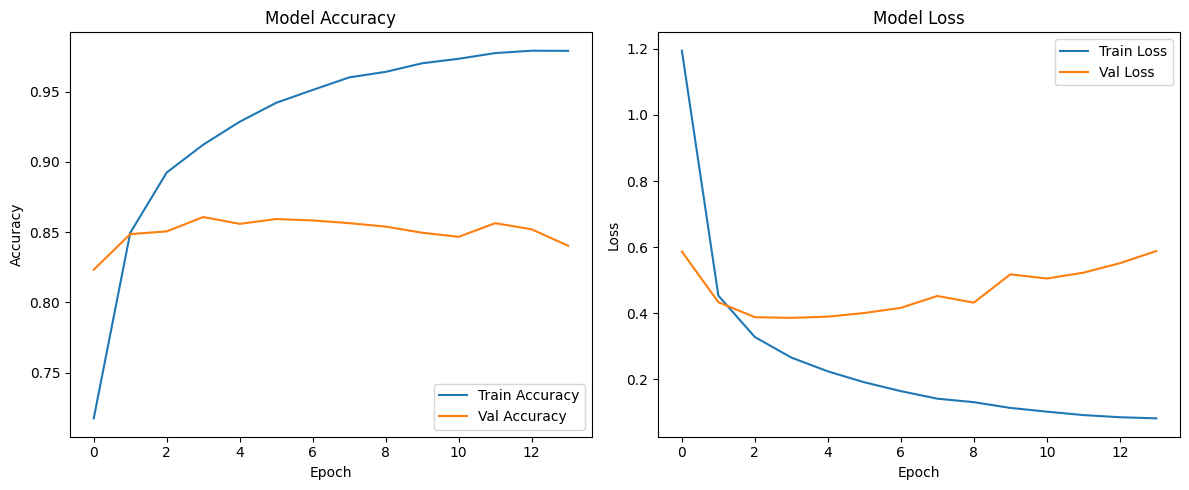

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()
